# 1. Introduction

Welcome to the Stock Price Prediction project using Long Short-Term Memory (LSTM) networks! In this project, we'll explore how to predict stock prices using historical data and an LSTM model. Stock price prediction is a challenging task due to its inherent volatility and dependency on various factors, making it an interesting problem for machine learning.

LSTM, a type of recurrent neural network (RNN), is well-suited for sequence prediction tasks like stock price prediction. Its ability to capture long-term dependencies in sequential data makes it a popular choice for time series forecasting.


In [ ]:
# Libraries
!pip install yfinance numpy pandas scikit-learn matplotlib

In [1]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

C:\Users\User\AppData\Local\Temp\ipykernel_11636\377692232.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# 2. Data Collection and Preprocessing

In [2]:
# Download Apple stock data from Yahoo Finance
ticker = 'AAPL'
data = yf.download(ticker, start='2022-01-01', end='2023-01-01')

# Select only the 'Close' column for prediction
data = data[['Close']]



[*********************100%%**********************]  1 of 1 completed


In [3]:
# Normalize Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


# 3. Data Preparation

In [4]:
# Function to create a dataset with time steps
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Calculate time_steps as a fraction of the dataset length
time_steps = int(len(data)*0.2)  # Use 20% of the dataset length as time steps
split_ratio = 0.8

# Create dataset with time steps
X, y = create_dataset(data_scaled,time_steps)

# Split dataset into train and test data
split = int(split_ratio * len(data))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 4. Model Building

In [5]:
# Define the model builder function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                   return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# 5. Hyperparameter Tuning

In [6]:
# Define the tuner and perform hyperparameter search
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5, 
    executions_per_trial=1,
    directory='keras_tuner_logs',
    project_name='stock_price_prediction')

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])


Reloading Tuner from keras_tuner_logs\stock_price_prediction\tuner0.json


# 6. Model Training

In [7]:
# Get the best hyperparameters and build the best model
best_hp = tuner.get_best_hyperparameters()[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hp)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


d:\Program Files\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - loss: 0.1526 - val_loss: 0.0136
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.0272 - val_loss: 0.0241
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.0181 - val_loss: 0.0214
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.0163 - val_loss: 0.0149
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.0134 - val_loss: 0.0291
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.0148 - val_loss: 0.0156
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.0097 - val_loss: 0.0182
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.0103 - val_loss: 0.0224
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.0111 - val_loss: 0.0126
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.0103 - val_loss: 0.0213
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.0090 - val_loss: 0.0132
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.0

# 7. Model Evaluation

In [8]:
# Predict stock prices
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(data[-len(predictions):], predictions))
print(f'Root Mean Squared Error: {rmse:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
Root Mean Squared Error: 1.05


8. Future Predictions

In [9]:
# Predict the next 3 months
future_steps = 90  # Approx. 3 months
last_sequence = data_scaled[-time_steps:]  # Last available sequence from the data

future_predictions = []

for _ in range(future_steps):
    next_pred = best_model.predict(last_sequence.reshape(1, time_steps, 1))
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
last_date = data.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, future_steps + 1)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

# 9. Results Visualization

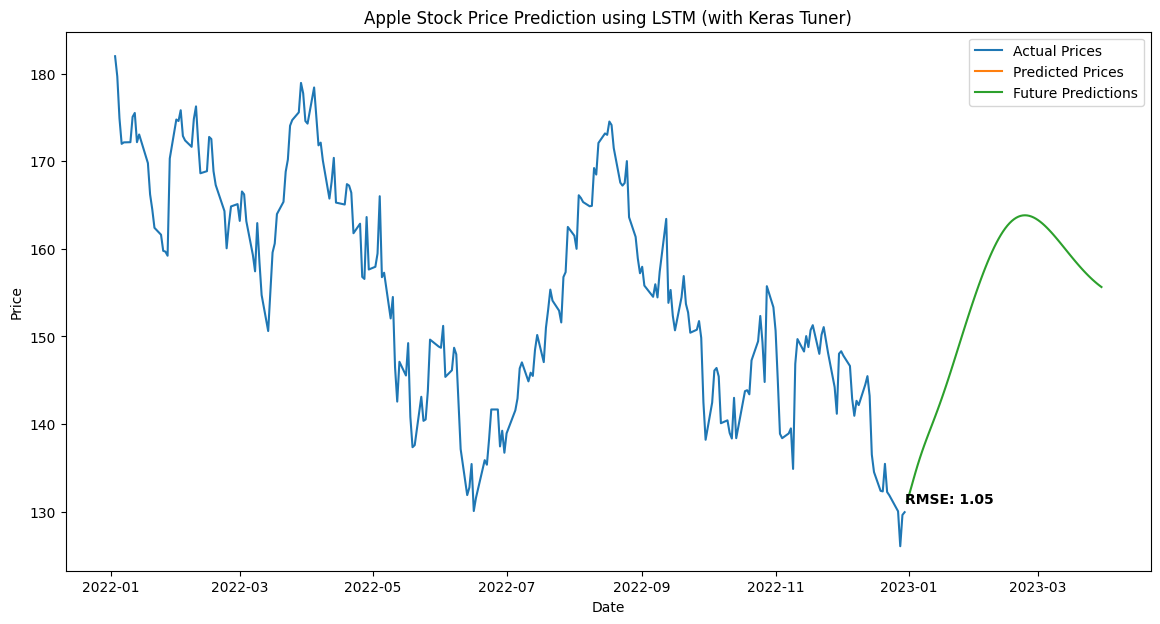

In [10]:
# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data, label='Actual Prices')
plt.plot(data.index[-len(predictions):], predictions, label='Predicted Prices')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Apple Stock Price Prediction using LSTM (with Keras Tuner)')
plt.legend()

# Add RMSE to the plot
plt.text(data.index[-1], predictions[-1], f'RMSE: {rmse:.2f}', horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.show()